In [2]:
#Import Packages
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
import pandas as pd
import camb 
from camb import model, initialpower
%matplotlib inline


In [2]:
def basicgenmap(_strt, _stop, _NSIDE):  # (start, stop, NSIDE)
    '''
    Generate a basic map which is just an array with element values which are increasing from a 'start' to a 'stop'.
    '''
    _NPIX = 12*_NSIDE**2 #The number of pixels in a map, NPIX = 12*(NSIDE)^2
    return   np.linspace(_strt,_stop,_NPIX)        #generates an array in the 'ring' scheme


In [4]:
#Downloads the higher resolution WMAP data as a array in the 'RING' scheme.
!healpy_get_wmap_maps.sh
wmap_map_I = hp.read_map("wmap_band_iqumap_r9_7yr_W_v4.fits")
hp.write_map("my_map.fits", wmap_map_I, overwrite=True)


URL transformed to HTTPS due to an HSTS policy
--2020-11-02 15:42:13--  https://lambda.gsfc.nasa.gov/data/map/dr4/skymaps/7yr/raw/wmap_band_iqumap_r9_7yr_W_v4.fits
Resolving lambda.gsfc.nasa.gov (lambda.gsfc.nasa.gov)... 129.164.179.68, 2001:4d0:2310:150::68
Connecting to lambda.gsfc.nasa.gov (lambda.gsfc.nasa.gov)|129.164.179.68|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

URL transformed to HTTPS due to an HSTS policy
--2020-11-02 15:42:14--  https://lambda.gsfc.nasa.gov/data/map/dr4/skymaps/7yr/raw/wmap_band_iqumap_r9_7yr_V_v4.fits
Resolving lambda.gsfc.nasa.gov (lambda.gsfc.nasa.gov)... 129.164.179.68, 2001:4d0:2310:150::68
Connecting to lambda.gsfc.nasa.gov (lambda.gsfc.nasa.gov)|129.164.179.68|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

URL transformed to HTTPS due t

NameError: name 'hp' is not defined

In [3]:
#Use CAMB to generate a power spectrum
def call_CAMB_map(_parameters, _lmax): #lmax above 2551 makes no difference?
    '''
    parameters = [H0, ombh2, omch2, mnu, omk, tau]  = [Hubble Const, Baryon density, DM density, 
    Sum 3 neutrino masses/eV, Curvature parameter (Omega kappa), Reionisation optical depth]
    '''
    if _lmax <= 2551: #can only find power spectrum for lmax <= 2551 since that is the maximum value of the data.
        pars = camb.CAMBparams()
        pars.set_cosmology(H0 = parameters[0], ombh2 = parameters[1], omch2 = parameters[2], mnu = parameters[3],
                   omk = parameters[4], tau = parameters[5])  #Inputs the given cosmological parameters.
        pars.InitPower.set_params(As=2e-9, ns=0.965, r=0)
        
        pars.set_for_lmax(_lmax, lens_potential_accuracy=0) #input the given lmax value
        
        results = camb.get_results(pars)
        powers =results.get_cmb_power_spectra(pars, CMB_unit='muK') #returns the power spectrum in units muK.
        
        totCL=powers['total'] #returns the total (averaged) power spectrum - including lensed, unlensed power spectra 
        _DL = totCL[:,0] 
        
        #unlensedCL=powers['unlensed_scalar'] #returns the unlensed scalar power spectrum
        #_DL = unlensedCL[:,0] # 
    
        _l = np.arange(len(_DL)) #not sure this CL is actually CL but is actually DL
        _CL = []
        for i in range(_lmax): #also limits the length of power spectrum to the requested length
            if i == 0:
                _CL.append(_DL[i]) #since unsure what CL value is for this DL
        
            else:
                _CL.append(_DL[i]/(_l[i]*(_l[i] + 1)))
        
        _CL = np.array(_CL)    
    
        return _CL 
    
    else: #prints error if lmax is too large.
        print('lmax value is larger than the available data.')

In [4]:
#PLots a map in the aithoff projection 
def aithoffmap(_map):
    hp.mollview(_map, title="Map displayed in the Aithoff projection", cmap = None)
    hp.graticule()


In [4]:
#Gives the resolution for an NSIDE and the number of pixels.
def basicmapdet(_NSIDE, _NPIX):     
    print("Approximate resolution at NSIDE {} is {:.2} deg".format(_NSIDE, hp.nside2resol(_NSIDE, arcmin=True) / 60))
    print('Number of pixels =',_NPIX)
    

In [5]:
#Generate a map given a power spectrum
def genmap(_cls, _NSIDE):   
    return hp.synfast(_cls, _NSIDE, new=True)   #pixwin=False, fwhm=np.radians(7.0),


In [6]:
#Generate a power spectrum given cls
def gencls(_map):
    return hp.anafast(_map, lmax=int(((3*(len(_map)/12)**0.5)-1)), new = True)    #lmax = 3NSIDE -1 by default


In [7]:
#Plots a given power spectrum 
def plotpwrspctrm(_cls):
    _l = np.arange(len(_cls))
    plt.figure()
    plt.plot(_l, _l * (_l + 1) * _cls)
    plt.xlabel("$\l$")
    plt.ylabel("$\l(\l+1)C_{\l}$")
    plt.grid()
    plt.title("Power Spectrum")
    plt.show()


In [16]:
#Adds random noise to each pixel on a map given a variance 
def noisemap(_map,_var):
    _noisevec = np.random.normal(0,_var,len(_map))
    _newmap = [x + y for x, y in zip(_map, _noisevec)]
    _newmap, _noisevec = np.array(_newmap), np.array(_noisevec)
    return [_newmap, _noisevec] #rerturns an array consisiting of [map with added noise, array of the added noise]


In [20]:
#Generate alms given cls
def genalms1(_cls, _NSIDE): #does this manually - doesn't work
    _alms = []
    _lmax = (3*_NSIDE) - 1
    for l in range(_lmax):
        _alms.append([]) 
        for m in range(_lmax): #set negative m's
            _alms[-1].append([np.random.normal(0,0.5*_cls[l]),np.random.normal(0,0.5*_cls[m])])
        _alms[-1].append([np.random.normal(0,_cls[l]),0.0])        #set m=0
        for m in range(_lmax):                    #set positive m's = -m's
            _alms[-1].append([_alms[l][(_lmax-m-1)][0]])
            _alms[-1][-1].append(-1.0*_alms[l][_lmax-m-1][-1])   #set imag part of positive m's = c.c. of negative m's.
    return _alms   


def genalms2(_cls, _NSIDE): #does this automatically
    return hp.synalm(_cls, lmax = ((3*_NSIDE)-1), new = True)

def maptoalms(_map, _lmax):
    return hp.map2alm(_map, _lmax)


In [9]:
def CLest(_alms, _lmax): #estimates the power spectrum from the cls.
    return hp.alm2cl(_alms, lmax = _lmax)

In [10]:
def mapsmooth(_map, _lmax): #smooths a given map with a gaussian beam smoother.
    return hp.smoothing(_map, lmax = _lmax)

def almsmooth(_alms): #smooths a given set of alms with a gaussian beam smoother.
    return hp.smoothalm(_alms, fwhm = 0.0)
    

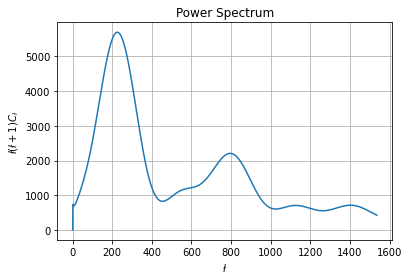

/home/oscar/anaconda3/envs/hp/lib/python3.7/site-packages/healpy/sphtfunc.py:824: UserWarning: Sigma is 0.000000 arcmin (0.000000 rad) 
  sigma * 60 * 180 / np.pi, sigma
/home/oscar/anaconda3/envs/hp/lib/python3.7/site-packages/healpy/sphtfunc.py:829: UserWarning: -> fwhm is 0.000000 arcmin
  sigma * 60 * 180 / np.pi * (2.0 * np.sqrt(2.0 * np.log(2.0)))
/home/oscar/anaconda3/envs/hp/lib/python3.7/site-packages/healpy/projaxes.py:920: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_over(newcm(1.0))
/home/oscar/anaconda3/envs/hp/lib/python3.7/site-packages/healpy/projaxes.py:921: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colorm

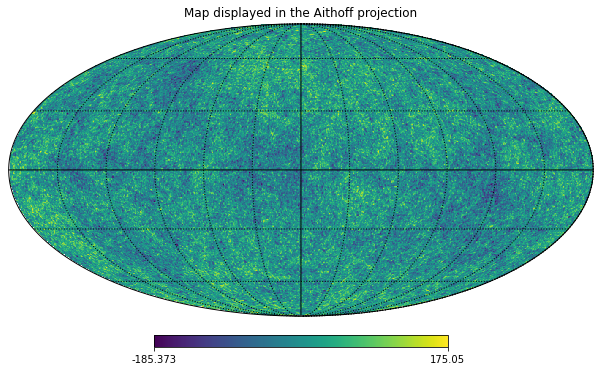

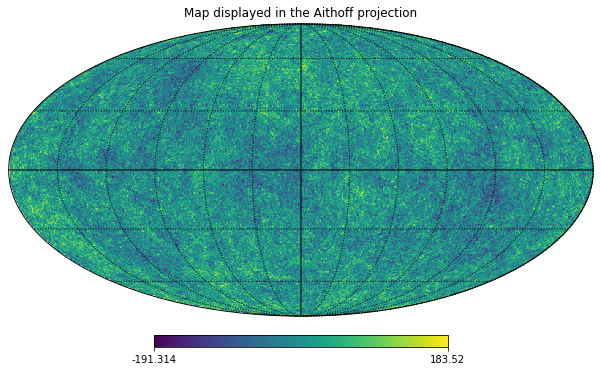

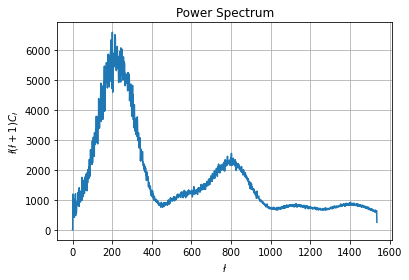

In [27]:
parameters1 = [67.74, 0.0486, 0.2589, 0.06, 0.0, 0.066] #cosmological parameters.
lmax1 = 1536  #lmax value wanted from data
cls1 = call_CAMB_map(parameters1, lmax1) #power spectrum for the given parameters and lmax.
plotpwrspctrm(cls1) #plot of the power spectrum.
NSIDE1 = 512  #len(cls1)/3   #3*nside = len(cls)
map1 = genmap(cls1, NSIDE1)  #generates a map from the power spectrum
map1 = mapsmooth(map1, lmax1) #applies a gaussian beam smoother to the map
aithoffmap(map1) #plots the map
noisemap1 = noisemap(map1,5) #adds noise to the map
aithoffmap(noisemap1[0]) #plots the map with noise
alms1 = maptoalms(noisemap1[0],lmax1) #computes the alms from the map with noise added.
CLestimate1 = CLest(alms1, lmax1) #estimates the power spectrum from the given alms.
plotpwrspctrm(CLestimate1) #plots the estimated power spectrum.


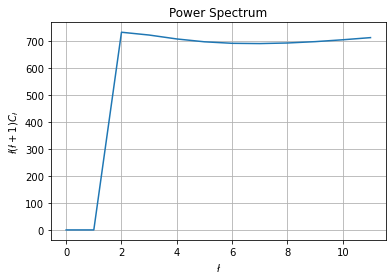

/home/oscar/anaconda3/envs/hp/lib/python3.7/site-packages/healpy/sphtfunc.py:824: UserWarning: Sigma is 0.000000 arcmin (0.000000 rad) 
  sigma * 60 * 180 / np.pi, sigma
/home/oscar/anaconda3/envs/hp/lib/python3.7/site-packages/healpy/sphtfunc.py:829: UserWarning: -> fwhm is 0.000000 arcmin
  sigma * 60 * 180 / np.pi * (2.0 * np.sqrt(2.0 * np.log(2.0)))
/home/oscar/anaconda3/envs/hp/lib/python3.7/site-packages/healpy/projaxes.py:920: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_over(newcm(1.0))
/home/oscar/anaconda3/envs/hp/lib/python3.7/site-packages/healpy/projaxes.py:921: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colorm

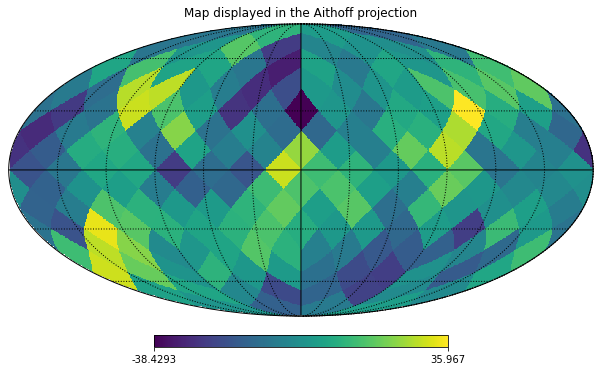

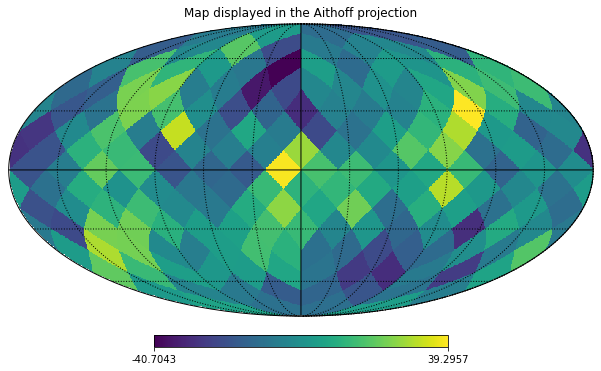

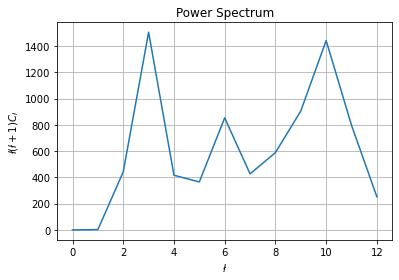

In [28]:
parameters2 = [67.74, 0.0486, 0.2589, 0.06, 0.0, 0.066] #cosmological parameters.
lmax2 = 12   #lmax value wanted from data
cls2 = call_CAMB_map(parameters2, lmax2) #power spectrum for the given parameters and lmax.
plotpwrspctrm(cls2) #plot of the power spectrum.
NSIDE2 = 4   #len(cls1)/3   #3*nside = len(cls)
map2 = genmap(cls2, NSIDE2)  #generates a map from the power spectrum
map2 = mapsmooth(map2, lmax2) #applies a gaussian beam smoother to the map
aithoffmap(map2) #plots the map
noisemap2 = noisemap(map2,5) #adds noise to the map
aithoffmap(noisemap2[0]) #plots the map with noise
alms2 = maptoalms(noisemap2[0],lmax2) #computes the alms from the map with noise added.
CLestimate2 = CLest(alms2, lmax2) #estimates the power spectrum from the given alms.
plotpwrspctrm(CLestimate2) #plots the estimated power spectrum.


In [24]:
a = almsmooth(alms1)
print(a)
print(len(a))

[  3.09023508 +0.j          -0.60726264 +0.j
 -27.18577399 +0.j           7.40387107 +0.j
  -8.05787921 +0.j          -0.11362383 +0.j
   7.31788049 +0.j           3.08123395 +0.j
   0.0522537  +0.j           3.24850146 +0.j
  -0.45265677 +0.j          -0.64988217 +0.j
   2.30203645 +0.j          -0.23322095 -0.12567809j
  -4.72497534 -4.52958596j  10.82924927 +2.84092269j
   1.46222651 -5.97556207j  -1.33027445 -6.66594833j
  -1.99155257 +0.70423967j  -6.03302398 +3.33794987j
  -1.12313946 +0.28382203j   4.83585425 +2.276513j
  -3.90973852 +1.60954911j   1.30459161 -2.58088153j
   1.06934921 +0.70662653j -12.1434023 +19.96144194j
  -2.76223751 +8.63989111j   8.56300165 +1.70351351j
  -0.07834157-10.45486744j  -1.44558165 -1.53328281j
  -0.10935214 -2.20290161j  -0.24813926 +2.32096547j
  -2.11184651 +0.81262244j  -1.45894101 +0.13931615j
  -0.14662097 +2.77408486j   1.22164546 +0.0894604j
  -3.12442741 -1.36577995j  -0.58758776 +1.91737923j
  -0.77860906 +0.93890896j   2.98652067 -0.9

In [29]:
#negative log of the posterior, psi, ignoring the prior term.
def psi(_noisemap): #unnormalised log probability
    _d = _noisemap[0]
    _a = maptoalms(_noisemap[0],lmax2)
    _BYa = almsmooth(_a)
    _n = _noisemap[1]
    Ninv = [(1/(i**2)) for i in _n] #finds the inverse noise matrix
    
    _elem, _psi = [], []
    for i in range(len(d)):
        _elem.append(_d[i] - _BYa[i])
        _psi.append(0.5*(_elem[i]**2)*_Ninv[i])
    
    return sum(_psi)

In [34]:
#Initialise HMC kernal
#tf.enable_eager_execution()

num_results = int(10e3)
num_burnin_steps = int(1e3)

adaptive_hmc = tfp.mcmc.SimpleStepSizeAdaptation(tfp.mcmc.HamiltonianMonteCarlo(target_log_prob_fn=psi, 
                        num_leapfrog_steps=3, step_size=1.), num_adaptation_steps=int(num_burnin_steps * 0.8))


#@tf.function

def run_chain():
  # Run the chain (with burn-in).
  samples, is_accepted = tfp.mcmc.sample_chain(num_results=num_results, num_burnin_steps=num_burnin_steps,
                        current_state=1., kernel=adaptive_hmc, trace_fn=lambda _,
                                               pkr: pkr.inner_results.is_accepted)

  sample_mean = tf.reduce_mean(samples)
  sample_stddev = tf.math.reduce_std(samples)
  is_accepted = tf.reduce_mean(tf.cast(is_accepted, dtype=tf.float32))
  return sample_mean, sample_stddev, is_accepted

sample_mean, sample_stddev, is_accepted = run_chain()

print('mean:{:.4f}  stddev:{:.4f}  acceptance:{:.4f}'.format(sample_mean.numpy(), sample_stddev.numpy(),
                                                             is_accepted.numpy()))

InvalidArgumentError: Index out of range using input dim 0; input has only 0 dims [Op:StridedSlice] name: mcmc_sample_chain/simple_step_size_adaptation___init__/_bootstrap_results/mh_bootstrap_results/hmc_kernel_bootstrap_results/maybe_call_fn_and_grads/value_and_gradients/strided_slice/